In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

from scipy.sparse import hstack

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/tejank10/Spam-or-Ham/master/spam.csv", encoding="latin1")

In [4]:
df = df.iloc[:, :2].copy()
df.columns = ['label', 'text']
df['label'] = pd.Categorical(df['label'])
#df['fake_feature'] = df['label'].cat.codes + np.random.randint(0, 100, len(df))
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
train, test = train_test_split(df, test_size=.2)

In [6]:
#vec = CountVectorizer(encoding='latin1')
vec = TfidfVectorizer(encoding='latin1', stop_words=stopwords.words("english"))
vec.fit(train['text'])
X_train = vec.transform(train['text'])
X_test = vec.transform(test['text'])

In [7]:
#X_train = hstack([train['fake_feature'].values.reshape(-1, 1), X_train])
X_train

<4457x7506 sparse matrix of type '<class 'numpy.float64'>'
	with 37608 stored elements in Compressed Sparse Row format>

In [8]:
#X_test = hstack([test['fake_feature'].values.reshape(-1, 1), X_test])
X_test

<1115x7506 sparse matrix of type '<class 'numpy.float64'>'
	with 8550 stored elements in Compressed Sparse Row format>

In [9]:
#model = xgb.XGBClassifier(max_depth=5, n_estimators=100)

In [10]:
#model.fit(X_train, train['label'].cat.codes)

In [11]:
xgb_classifier = xgb.XGBClassifier()

parameters = {'n_estimators':list(range(100, 1000, 300)),
              'max_depth':list(range(1, 4, 2)),
              #'learning_rate':[i/100 for i in range(10, 90, 10)],
              'min_child_weight':[2,4,6,8],
             }

clf = GridSearchCV(xgb_classifier,
                   param_grid = parameters,
                   cv=5,
                   verbose=1,
                   n_jobs=3,
                   return_train_score=True,
                   scoring='neg_log_loss',
                  )
clf.fit(X_train, train['label'].cat.codes)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'n_estimators': [100, 400, 700], 'max_depth': [1, 3], 'min_child_weight': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [13]:
final_model = clf.best_estimator_
final_model.fit(X_train, train['label'].cat.codes)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
fi = pd.DataFrame(list(
    zip(
        #['fake_feature'] + vec.get_feature_names(),
        vec.get_feature_names(),
        final_model.feature_importances_)),
                  columns=['name', 'importance']
).sort_values('importance', ascending=False)

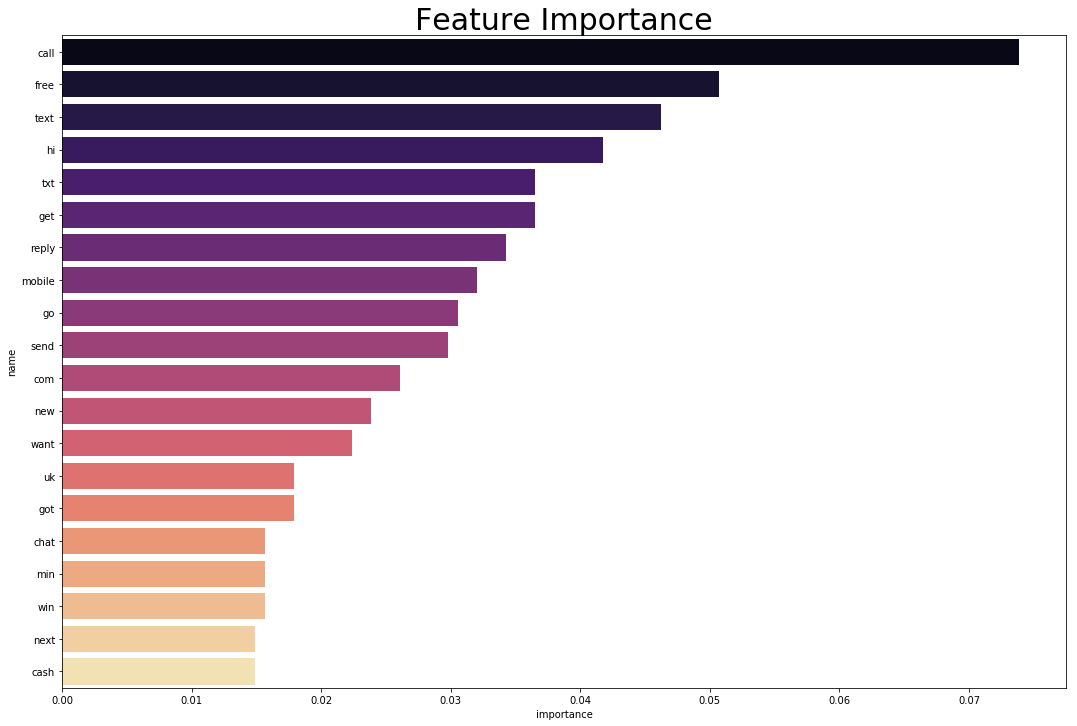

In [15]:
f, ax = plt.subplots(figsize=(18,12))
ax.set_title('Feature Importance', {"fontsize": 30})
sns.barplot(x="importance", y="name", data=fi.head(20), ax=ax, palette="magma", estimator=sum)

In [16]:
#final model score
final_model.score(X_test, test['label'].cat.codes)

0.9721973094170404

In [17]:
#naive score
np.max(test.groupby('label')['text'].count()) / len(test)

0.8618834080717489

In [18]:
def add_prediction(df, true_y, model, pred_proba=True):
    df['prediction'] = model.predict(X_test)
    if df[true_y].dtypes.name == 'category':
        df['prediction'] = df['prediction'].map(
            dict(enumerate(df[true_y].cat.categories)))
    if pred_proba:
        df['pred_proba'] = np.max(
            model.predict_proba(X_test), axis=1)
    return df

In [19]:
def print_top_n_prediction(df, n, label):
    for i in df[df['label']==label].reset_index().itertuples():
        if i[0] > n:
            break
        print(f"""True Label = {i[2]}, Prediction = {i[4]}, Prediction Probability = {i[5]:.4f}
--------------------------------------------------------------------------------------------
{i[3].strip()}\n\n""")

In [20]:
test_copy = (test.copy()
                 .pipe(add_prediction, 'label', final_model)
                 .sort_values('pred_proba', ascending=False))

In [21]:
print_top_n_prediction(test_copy, 5, 'spam')

True Label = spam, Prediction = spam, Prediction Probability = 1.0000
--------------------------------------------------------------------------------------------
Do you want a New Nokia 3510i Colour Phone Delivered Tomorrow? With 200 FREE minutes to any mobile + 100 FREE text + FREE camcorder Reply or Call 8000930705


True Label = spam, Prediction = spam, Prediction Probability = 1.0000
--------------------------------------------------------------------------------------------
Do you want 750 anytime any network mins 150 text and a NEW video phone for only five pounds per week call 08000776320 now or reply for delivery Tomorrow


True Label = spam, Prediction = spam, Prediction Probability = 1.0000
--------------------------------------------------------------------------------------------
Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply


True Label = spam, Prediction = spam, 

In [22]:
print_top_n_prediction(test_copy, 5, 'ham')

True Label = ham, Prediction = ham, Prediction Probability = 0.9999
--------------------------------------------------------------------------------------------
My friend just got here and says he's upping his order by a few grams (he's got $ &lt;#&gt; ), when can you get here?


True Label = ham, Prediction = ham, Prediction Probability = 0.9998
--------------------------------------------------------------------------------------------
Dear we got  &lt;#&gt;  dollars hi hi


True Label = ham, Prediction = ham, Prediction Probability = 0.9997
--------------------------------------------------------------------------------------------
I will cme i want to go to hos 2morow. After that i wil cme. This what i got from her dear what to do. She didnt say any time


True Label = ham, Prediction = ham, Prediction Probability = 0.9995
--------------------------------------------------------------------------------------------
U gd lor go shopping i got stuff to do. U wan 2 watch infernal affai